Versuch 4 - Code
1. Aufgabe - Fourieranalyse lang andauernder Signale
- beliebige Spracheingabe in einem Diagramm darstellen:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
from scipy.signal import gausspulse
from scipy.signal.windows import gaussian
import os

running
Data saved as spracheingabe1.npy


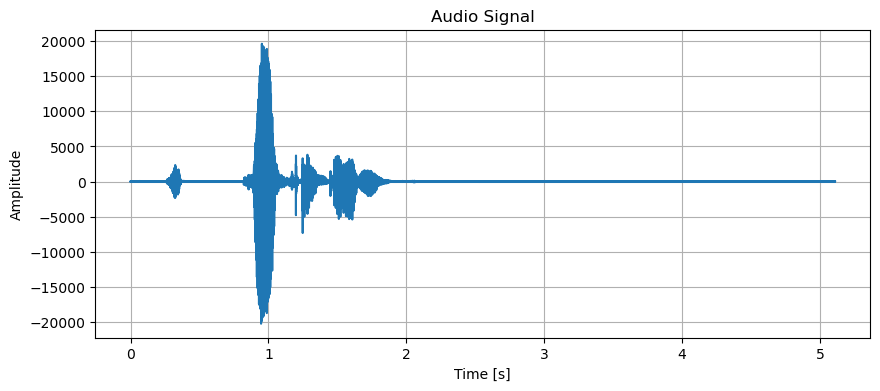

In [3]:
# Audio recording parameters
FORMAT = pyaudio.paInt16
SAMPLEFREQ = 44100
FRAMESIZE = 1024
NOFFRAMES = 220

# Initialize PyAudio
p = pyaudio.PyAudio()
print('running')

# Open stream
stream = p.open(format=FORMAT, channels=1, rate=SAMPLEFREQ,
                input=True, frames_per_buffer=FRAMESIZE)

# Read audio data
data = stream.read(NOFFRAMES * FRAMESIZE)
decoded = np.frombuffer(data, dtype=np.int16)

# Close stream
stream.stop_stream()
stream.close()
p.terminate()

# Generate a unique filename
filename = "spracheingabe1.npy"
np.save(filename, decoded)
print(f'Data saved as {filename}')

# Plotting the audio data
time_axis = np.linspace(0, len(decoded) / SAMPLEFREQ, num=len(decoded))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, decoded)
plt.title('Audio Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


*Zuschnitt des Signals ab dem Triggerzeitpunkt und Darstellung des Audiosignals und Amplitudenspektrums:*

Trimmed data saved as spracheingabe1_trimmed.npy


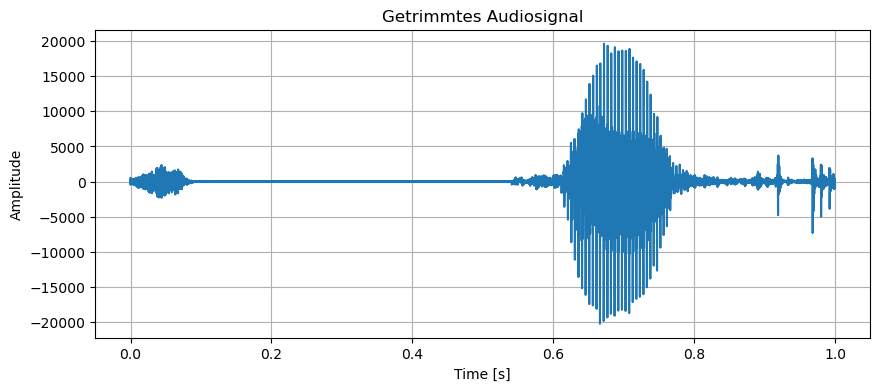

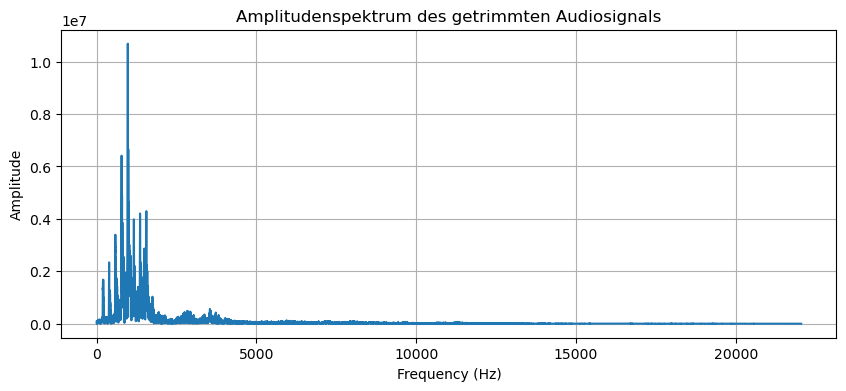

In [4]:
# Triggerfunktion, Index des ersten Wertes finden, der über dem Schwellenwert liegt
def find_trigger_point(audio_data, threshold=500):
    for i in range(len(audio_data)):
        if abs(audio_data[i]) > threshold:
            return i                    #Wert , der Schwelle überschreitet
    return 0

#Funktion, um Signal zum Triggerzeitpunkt abzuschneiden (1 Sekunde lang)
def trim_signal(audio_data, trigger_point, sample_rate=44100):
    end_point = trigger_point + sample_rate       #Triggerpunkt + Abtastrate  
    trimmed_signal = audio_data[trigger_point:end_point]
    #Länge des Signals überprüfen
    if len(trimmed_signal) < sample_rate:
        trimmed_signal = np.pad(trimmed_signal, (0, sample_rate - len(trimmed_signal)), 'constant') #mit 0-len füllen 
    return trimmed_signal

#Funktionsaufruf 
trigger_point = find_trigger_point(decoded, threshold=500)
trimmed_audio = trim_signal(decoded, trigger_point, sample_rate=SAMPLEFREQ)

#File speichern
trimmed_filename = "spracheingabe1_trimmed.npy"
np.save(trimmed_filename, trimmed_audio)
print(f'Trimmed data saved as {trimmed_filename}')

# Plot trimmed audio signal
time_axis_trimmed = np.linspace(0, len(trimmed_audio) / SAMPLEFREQ, num=len(trimmed_audio)) 

plt.figure(figsize=(10, 4))
plt.plot(time_axis_trimmed, trimmed_audio)
plt.title('Getrimmtes Audiosignal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# Plotting Amplitudenspektrum
N = len(trimmed_audio)
fft_result = np.fft.fft(trimmed_audio)
magnitude_spectrum = np.abs(fft_result)
frequency_axis = np.fft.fftfreq(N, 1.0 / SAMPLEFREQ)

plt.figure(figsize=(10, 4))
plt.plot(frequency_axis[:N//2], magnitude_spectrum[:N//2])
plt.title('Amplitudenspektrum des getrimmten Audiosignals')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

*Windowing Methode und Darstellung des Amplitudenspektrums*

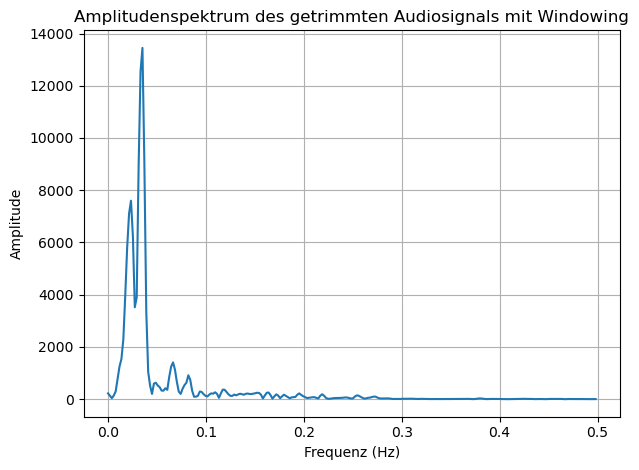

In [5]:
# Funktion zur Anwendung des Windowing und Berechnung des Amplitudenspektrums
def windowing(signal, window_length=512, overlap=0.5):
    # Berechnung der Anzahl der Fenster
    step = int(window_length * (1 - overlap))
    num_windows = (len(signal) - window_length) // step + 1
    
    std_dev = window_length / 8  # Fensterbreite = 4 * std_dev für jedes Fenster
    window = gaussian(window_length, std_dev) #Gaußsche Fensterfunktion 
    
    # Initialisierung für gemittelte Fouriertransformierte
    avg_fft = np.zeros(window_length, dtype=np.complex128)
    
    # Anwenden des Windowing und Durchführung der lokalen Fouriertransformation für jedes Fenster
    for i in range(num_windows):
        start = i * step
        end = start + window_length
        #aktuelle Fenster
        segment = signal[start:end] * window  # Fensterfunktion anwenden 
        segment_fft = np.fft.fft(segment) #Fouriertransforamtion 
        avg_fft += segment_fft #zum Durchschnitt hinzufügen
    
    # Mittelung der Fouriertransformierten
    avg_fft /= num_windows
    
    # Berechnung des Amplitudenspektrums
    amplitude_spectrum = np.abs(avg_fft)[:window_length//2] # Amplituden der Frequenzkomponenten aus der gemittelten Fouriertransformierten
    frequency_axis = np.fft.fftfreq(window_length, d=1.0)[:window_length//2] #Achse 
    
    return frequency_axis, amplitude_spectrum

# Laden des bereits getrimmten Audiosignals
trimmed_filename = "spracheingabe1_trimmed.npy"
trimmed_audio = np.load(trimmed_filename)

# Anwenden des Windowing und Berechnung des Amplitudenspektrums
frequency_axis_windowed, amplitude_spectrum_windowed = windowing(trimmed_audio, window_length=512, overlap=0.5)


# Plot des Amplitudenspektrums mit und ohne Windowing zur Überprüfung
plt.plot(frequency_axis_windowed, amplitude_spectrum_windowed)
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')
plt.title('Amplitudenspektrum des getrimmten Audiosignals mit Windowing')
plt.grid(True)

plt.tight_layout()
plt.show()


*Vergleich vor Windowing und nach Windowing:*
- vor windowing: klare, scharfe Peaks
- nach Windowing hat man eine geglättete Darstellung der Spektralkomponenten (--> Einfluss der Gaußsche Fensterfunktion)


	2. Spracherkennung

*Referenzspektren berechnen*

In [7]:
# Hauptteil des Codes
directory_path = directory_path = r"C:\Users\pbegu\OneDrive\Dokumente\Hs-Studium\3_SS 24\SSS\Übungen\SSS-1\SSS\versuch4\Begüm"
commands = ["hoch", "links", "rechts", "tief"]
bsp_pro_command = 5  # Anzahl der Beispiele pro Befehl

ref_spec_hoch = None
ref_spec_tief = None
ref_spec_rechts = None
ref_spec_links = None

for command in commands:
    spec = []
    for i in range(1, bsp_pro_command + 1):
        filename = os.path.join(directory_path, f"{command}{i}.npy")  # Dateiname basierend auf dem Befehl und Index
        
        if not os.path.exists(filename):
            print(f"Datei {filename} existiert nicht!")
            continue
        
        try:
            audio = np.load(filename, allow_pickle=True)  # Laden der Audiodaten mit Pickle-Erlaubnis
        except Exception as e:
            print(f"Fehler beim Laden von {filename}: {e}")
            continue

        # Überprüfen, ob das geladene Audio-Signal die erwartete Form hat
        if not isinstance(audio, np.ndarray):
            print(f"Unerwarteter Datentyp in {filename}: {type(audio)}")
            continue

        if audio.ndim != 1:
            print(f"Unerwartete Form der Audiodaten in {filename}: {audio.shape}")
            continue

        frequency_axis, amplitude_spectrum_windowed = windowing(audio, window_length=512, overlap=0.5)  # Windowing-Methode anwenden
        spec.append(amplitude_spectrum_windowed)  # Amplitudenspektrum hinzufügen

    if not spec:
        print(f"Keine gültigen Daten für den Befehl '{command}' gefunden.")
        continue



# Berechnung des Referenzspektrums durch Mittelung
ref_spec = np.mean(spec, axis=0)

#Referenzspektrum speichern
if command == "hoch":
    ref_spec_hoch = ref_spec
elif command == "tief":
    ref_spec_tief = ref_spec
elif command == "links":
    ref_spec_links = ref_spec
elif command == "rechts":
    ref_spec_rechts = ref_spec

# Plotting des Referenzspektrums
plt.figure()
plt.plot(frequency_axis, ref_spec)
plt.title(f"Referenzspektrum für Befehl '{command}'")
plt.xlabel("Frequenz (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2676455302.py, line 2)

*Bravais-Pearson Korrelationskoeffizienten Berechnung*

In [ ]:
#Korrelationskoeffizienten berechnen nach Pearson
def pearson_correlation(x, y):
    
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    x_deviation = x - mean_x
    y_deviation = y - mean_y
    covariance = np.sum(x_deviation * y_deviation) / len(x)
    std_x = np.std(x)
    std_y = np.std(y)

    corr = covariance / (std_x * std_y)

    return corr

_, test_spectrum = windowing( test_audio, window_length=512, overlap=0.5)

print("Vergleich der Eingabespektren")
corr_hoch = pearson_correlation(test_spectrum, ref_spec_hoch)
corr_tief = pearson_correlation(test_spectrum, ref_spec_tief)
corr_rechts = pearson_correlation(test_spectrum, ref_spec_rechts)
corr_links = pearson_correlation(test_spectrum, ref_spec_links)

print(f"Korrelation hoch: {corr_hoch}")
print(f"Korrelation tief: {corr_tief}")
print(f"Korrelation rechts: {corr_rechts}")
print(f"Korrelation links: {corr_links}")

print(f"Korrelation hoch vs hoch:", pearson_correlation(ref_spec_hoch, ref_spec_hoch))
print(f"Korrelation hoch vs tief:", pearson_correlation(ref_spec_hoch, ref_spec_tief))
print(f"Korrelation hoch vs rechts:", pearson_correlation(ref_spec_hoch, ref_spec_rechts))
print(f"Korrelation hoch vs links:", pearson_correlation(ref_spec_hoch, ref_spec_links))


Vergleich der Eingabespektren


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

*Spracherkenner implementieren*
- *Detektions und Fehlerrate ausgeben*

In [ ]:


def spracherkenner(spektrum):
    referenz_spektren = [ref_spec_hoch, ref_spec_tief, ref_spec_links, ref_spec_rechts]
    max_corr = 0
    predicted_command = None
    for i, ref_spec in enumerate(referenz_spektren):
        temp_corr = pearson_correlation(spektrum, ref_spec)
        if temp_corr > max_corr:
            max_corr = temp_corr
            if i == 0:
                predicted_command = "hoch"
            elif i == 1:
                predicted_command = "tief"
            elif i == 2:
                predicted_command = "links"
            else:
                predicted_command = "rechts"
    return predicted_command

# Testdaten laden
test_directory = "C:/Users/ellen/OneDrive/Documents/Studium/Semester3/sss/Versuche/SSS/versuch4/Ellen"
test_files = os.listdir(test_directory)

# Zähler für korrekte und falsche Klassifizierungen
correct_count = 0
incorrect_count = 0

for test_file in test_files:
    test_path = os.path.join(test_directory, test_file)
    test_audio = np.load(test_path, allow_pickle=True)
    
    # Amplitudenspektrum der Testdatei berechnen
    _, test_spectrum = windowing(test_audio, window_length=512, overlap=0.5)
    
    # Klassifizierung mit dem Spracherkenner
    predicted_command = spracherkenner(test_spectrum)
    
    # Zählen der korrekten und falschen Klassifizierungen
    expected_command = test_file.split("_")[0]
    if predicted_command == expected_command:
        correct_count += 1
    else:
        incorrect_count += 1

# Berechnung der Detektions- und Fehlerrate
total_count = correct_count + incorrect_count
detection_rate = correct_count / total_count * 100
error_rate = incorrect_count / total_count * 100

print(f"Detektionsrate: {detection_rate:.2f}%")
print(f"Fehlerrate: {error_rate:.2f}%")

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'